In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [2]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [3]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    #data.loc[data.Concrete_Offer <= 0, 'Concrete_Offer'] = 0
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    #data.loc[data.Offer_Duration <= 0, 'Offer_Duration'] = -1
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    #data.loc[(data.Past_Quote <= 100) & (data.Past_Quote > 0), 'Past_Quote'] = 1
    #data.loc[(data.Past_Quote >= -100) & (data.Past_Quote < 0), 'Past_Quote'] = -1
    #data.loc[data.Past_Quote < -100, 'Past_Quote'] = -2
    #data.loc[data.Past_Quote > 100, 'Past_Quote'] = 2
    #data['Past_Quote'].astype('category')
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [4]:
import catboost as ctb

In [5]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [6]:
rest = [x for x in data.columns if x != 'ID']
len(data[data.duplicated(rest)])/float(len(data)) * 100

2.643535729037588

In [7]:
prep = preprocess(data)

In [8]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [9]:
len(prep[prep.duplicated()])

481

In [10]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [11]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [806]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [12]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [808]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [13]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True)

In [14]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6679531	test: 0.6682930	best: 0.6682930 (0)	total: 247ms	remaining: 20m 33s
1:	learn: 0.6465240	test: 0.6471160	best: 0.6471160 (1)	total: 283ms	remaining: 11m 47s
2:	learn: 0.6235090	test: 0.6242381	best: 0.6242381 (2)	total: 348ms	remaining: 9m 39s
3:	learn: 0.6031314	test: 0.6040542	best: 0.6040542 (3)	total: 393ms	remaining: 8m 10s
4:	learn: 0.5820636	test: 0.5832737	best: 0.5832737 (4)	total: 548ms	remaining: 9m 7s
5:	learn: 0.5622983	test: 0.5637942	best: 0.5637942 (5)	total: 726ms	remaining: 10m 4s
6:	learn: 0.5442029	test: 0.5459132	best: 0.5459132 (6)	total: 792ms	remaining: 9m 25s
7:	learn: 0.5280871	test: 0.5299992	best: 0.5299992 (7)	total: 851ms	remaining: 8m 50s
8:	learn: 0.5089577	test: 0.5111354	best: 0.5111354 (8)	total: 1.02s	remaining: 9m 28s
9:	learn: 0.4926150	test: 0.4947746	best: 0.4947746 (9)	total: 1.14s	remaining: 9m 29s
10:	learn: 0.4787206	test: 0.4810805	best: 0.4810805 (10)	total: 1.16s	remaining: 8m 45s
11:	learn: 0.4637352	test: 0.4662901	bes

94:	learn: 0.1225270	test: 0.1332724	best: 0.1332724 (94)	total: 11.5s	remaining: 9m 51s
95:	learn: 0.1217402	test: 0.1325520	best: 0.1325520 (95)	total: 11.6s	remaining: 9m 51s
96:	learn: 0.1210545	test: 0.1319365	best: 0.1319365 (96)	total: 11.7s	remaining: 9m 53s
97:	learn: 0.1205356	test: 0.1315025	best: 0.1315025 (97)	total: 11.9s	remaining: 9m 54s
98:	learn: 0.1197669	test: 0.1308653	best: 0.1308653 (98)	total: 12s	remaining: 9m 56s
99:	learn: 0.1192694	test: 0.1304064	best: 0.1304064 (99)	total: 12.2s	remaining: 9m 56s
100:	learn: 0.1184521	test: 0.1297233	best: 0.1297233 (100)	total: 12.3s	remaining: 9m 57s
101:	learn: 0.1178756	test: 0.1291871	best: 0.1291871 (101)	total: 12.4s	remaining: 9m 57s
102:	learn: 0.1173354	test: 0.1286600	best: 0.1286600 (102)	total: 12.6s	remaining: 9m 58s
103:	learn: 0.1166955	test: 0.1280964	best: 0.1280964 (103)	total: 12.7s	remaining: 9m 58s
104:	learn: 0.1162788	test: 0.1277391	best: 0.1277391 (104)	total: 12.8s	remaining: 9m 58s
105:	learn: 0

185:	learn: 0.0909343	test: 0.1057362	best: 0.1057362 (185)	total: 24.8s	remaining: 10m 42s
186:	learn: 0.0909322	test: 0.1057380	best: 0.1057362 (185)	total: 24.8s	remaining: 10m 39s
187:	learn: 0.0907441	test: 0.1055908	best: 0.1055908 (187)	total: 25s	remaining: 10m 39s
188:	learn: 0.0905437	test: 0.1054757	best: 0.1054757 (188)	total: 25.2s	remaining: 10m 40s
189:	learn: 0.0902077	test: 0.1051102	best: 0.1051102 (189)	total: 25.3s	remaining: 10m 41s
190:	learn: 0.0900979	test: 0.1049969	best: 0.1049969 (190)	total: 25.5s	remaining: 10m 42s
191:	learn: 0.0900959	test: 0.1049986	best: 0.1049969 (190)	total: 25.6s	remaining: 10m 40s
192:	learn: 0.0899814	test: 0.1049185	best: 0.1049185 (192)	total: 25.7s	remaining: 10m 40s
193:	learn: 0.0897303	test: 0.1047118	best: 0.1047118 (193)	total: 25.9s	remaining: 10m 40s
194:	learn: 0.0894615	test: 0.1044899	best: 0.1044899 (194)	total: 26.1s	remaining: 10m 41s
195:	learn: 0.0891919	test: 0.1042384	best: 0.1042384 (195)	total: 26.2s	remaining

276:	learn: 0.0805701	test: 0.0975555	best: 0.0975555 (276)	total: 36.8s	remaining: 10m 28s
277:	learn: 0.0805150	test: 0.0975388	best: 0.0975388 (277)	total: 37s	remaining: 10m 28s
278:	learn: 0.0803259	test: 0.0973701	best: 0.0973701 (278)	total: 37.1s	remaining: 10m 27s
279:	learn: 0.0803234	test: 0.0973697	best: 0.0973697 (279)	total: 37.2s	remaining: 10m 26s
280:	learn: 0.0801777	test: 0.0972821	best: 0.0972821 (280)	total: 37.4s	remaining: 10m 27s
281:	learn: 0.0799402	test: 0.0971628	best: 0.0971628 (281)	total: 37.6s	remaining: 10m 28s
282:	learn: 0.0797395	test: 0.0970405	best: 0.0970405 (282)	total: 37.7s	remaining: 10m 28s
283:	learn: 0.0797382	test: 0.0970415	best: 0.0970405 (282)	total: 37.7s	remaining: 10m 26s
284:	learn: 0.0797045	test: 0.0970322	best: 0.0970322 (284)	total: 37.8s	remaining: 10m 26s
285:	learn: 0.0796341	test: 0.0969615	best: 0.0969615 (285)	total: 38s	remaining: 10m 26s
286:	learn: 0.0794679	test: 0.0968514	best: 0.0968514 (286)	total: 38.1s	remaining: 

366:	learn: 0.0739009	test: 0.0925905	best: 0.0925905 (366)	total: 45.5s	remaining: 9m 34s
367:	learn: 0.0737210	test: 0.0925084	best: 0.0925084 (367)	total: 45.6s	remaining: 9m 34s
368:	learn: 0.0737143	test: 0.0925031	best: 0.0925031 (368)	total: 45.7s	remaining: 9m 33s
369:	learn: 0.0736338	test: 0.0924255	best: 0.0924255 (369)	total: 45.8s	remaining: 9m 33s
370:	learn: 0.0736301	test: 0.0924225	best: 0.0924225 (370)	total: 45.9s	remaining: 9m 32s
371:	learn: 0.0734751	test: 0.0923006	best: 0.0923006 (371)	total: 46s	remaining: 9m 32s
372:	learn: 0.0734296	test: 0.0922632	best: 0.0922632 (372)	total: 46.1s	remaining: 9m 31s
373:	learn: 0.0732854	test: 0.0921196	best: 0.0921196 (373)	total: 46.2s	remaining: 9m 31s
374:	learn: 0.0732546	test: 0.0921096	best: 0.0921096 (374)	total: 46.3s	remaining: 9m 31s
375:	learn: 0.0731779	test: 0.0920507	best: 0.0920507 (375)	total: 46.4s	remaining: 9m 30s
376:	learn: 0.0729961	test: 0.0919010	best: 0.0919010 (376)	total: 46.5s	remaining: 9m 30s
3

459:	learn: 0.0679569	test: 0.0887596	best: 0.0887596 (459)	total: 54.8s	remaining: 9m
460:	learn: 0.0679240	test: 0.0887446	best: 0.0887446 (460)	total: 54.9s	remaining: 9m
461:	learn: 0.0679092	test: 0.0887399	best: 0.0887399 (461)	total: 55s	remaining: 9m
462:	learn: 0.0678244	test: 0.0886555	best: 0.0886555 (462)	total: 55.2s	remaining: 9m
463:	learn: 0.0678060	test: 0.0886280	best: 0.0886280 (463)	total: 55.3s	remaining: 9m
464:	learn: 0.0677570	test: 0.0885624	best: 0.0885624 (464)	total: 55.4s	remaining: 9m
465:	learn: 0.0677204	test: 0.0885469	best: 0.0885469 (465)	total: 55.5s	remaining: 9m
466:	learn: 0.0677141	test: 0.0885452	best: 0.0885452 (466)	total: 55.7s	remaining: 9m
467:	learn: 0.0676187	test: 0.0884752	best: 0.0884752 (467)	total: 55.8s	remaining: 9m
468:	learn: 0.0675362	test: 0.0884003	best: 0.0884003 (468)	total: 55.9s	remaining: 9m
469:	learn: 0.0675080	test: 0.0883809	best: 0.0883809 (469)	total: 56.1s	remaining: 9m
470:	learn: 0.0673599	test: 0.0883177	best: 0

550:	learn: 0.0633489	test: 0.0856343	best: 0.0856343 (550)	total: 1m 4s	remaining: 8m 43s
551:	learn: 0.0632423	test: 0.0855459	best: 0.0855459 (551)	total: 1m 4s	remaining: 8m 43s
552:	learn: 0.0631512	test: 0.0854946	best: 0.0854946 (552)	total: 1m 5s	remaining: 8m 44s
553:	learn: 0.0631440	test: 0.0854976	best: 0.0854946 (552)	total: 1m 5s	remaining: 8m 44s
554:	learn: 0.0631018	test: 0.0854643	best: 0.0854643 (554)	total: 1m 5s	remaining: 8m 44s
555:	learn: 0.0629970	test: 0.0854348	best: 0.0854348 (555)	total: 1m 5s	remaining: 8m 44s
556:	learn: 0.0629465	test: 0.0854249	best: 0.0854249 (556)	total: 1m 5s	remaining: 8m 44s
557:	learn: 0.0627845	test: 0.0852831	best: 0.0852831 (557)	total: 1m 5s	remaining: 8m 44s
558:	learn: 0.0627826	test: 0.0852823	best: 0.0852823 (558)	total: 1m 5s	remaining: 8m 44s
559:	learn: 0.0627649	test: 0.0852826	best: 0.0852823 (558)	total: 1m 6s	remaining: 8m 44s
560:	learn: 0.0627118	test: 0.0852402	best: 0.0852402 (560)	total: 1m 6s	remaining: 8m 44s

640:	learn: 0.0597877	test: 0.0834614	best: 0.0834568 (639)	total: 1m 15s	remaining: 8m 32s
641:	learn: 0.0597558	test: 0.0834449	best: 0.0834449 (641)	total: 1m 15s	remaining: 8m 32s
642:	learn: 0.0595986	test: 0.0833090	best: 0.0833090 (642)	total: 1m 15s	remaining: 8m 31s
643:	learn: 0.0595920	test: 0.0833084	best: 0.0833084 (643)	total: 1m 15s	remaining: 8m 31s
644:	learn: 0.0595847	test: 0.0833069	best: 0.0833069 (644)	total: 1m 15s	remaining: 8m 31s
645:	learn: 0.0595847	test: 0.0833069	best: 0.0833069 (645)	total: 1m 15s	remaining: 8m 30s
646:	learn: 0.0595280	test: 0.0832906	best: 0.0832906 (646)	total: 1m 15s	remaining: 8m 30s
647:	learn: 0.0595172	test: 0.0832864	best: 0.0832864 (647)	total: 1m 15s	remaining: 8m 30s
648:	learn: 0.0594867	test: 0.0832724	best: 0.0832724 (648)	total: 1m 16s	remaining: 8m 29s
649:	learn: 0.0594738	test: 0.0832697	best: 0.0832697 (649)	total: 1m 16s	remaining: 8m 29s
650:	learn: 0.0594738	test: 0.0832697	best: 0.0832697 (650)	total: 1m 16s	remain

731:	learn: 0.0569126	test: 0.0817787	best: 0.0817780 (730)	total: 1m 23s	remaining: 8m 7s
732:	learn: 0.0568254	test: 0.0816890	best: 0.0816890 (732)	total: 1m 23s	remaining: 8m 7s
733:	learn: 0.0568098	test: 0.0816849	best: 0.0816849 (733)	total: 1m 23s	remaining: 8m 7s
734:	learn: 0.0568098	test: 0.0816849	best: 0.0816849 (734)	total: 1m 23s	remaining: 8m 6s
735:	learn: 0.0567502	test: 0.0816669	best: 0.0816669 (735)	total: 1m 23s	remaining: 8m 6s
736:	learn: 0.0567362	test: 0.0816670	best: 0.0816669 (735)	total: 1m 24s	remaining: 8m 6s
737:	learn: 0.0565935	test: 0.0815523	best: 0.0815523 (737)	total: 1m 24s	remaining: 8m 6s
738:	learn: 0.0565935	test: 0.0815523	best: 0.0815523 (738)	total: 1m 24s	remaining: 8m 6s
739:	learn: 0.0565862	test: 0.0815510	best: 0.0815510 (739)	total: 1m 24s	remaining: 8m 6s
740:	learn: 0.0565698	test: 0.0815444	best: 0.0815444 (740)	total: 1m 24s	remaining: 8m 6s
741:	learn: 0.0564425	test: 0.0814115	best: 0.0814115 (741)	total: 1m 24s	remaining: 8m 6s

823:	learn: 0.0537356	test: 0.0799305	best: 0.0799305 (823)	total: 1m 35s	remaining: 8m 2s
824:	learn: 0.0537252	test: 0.0799296	best: 0.0799296 (824)	total: 1m 35s	remaining: 8m 2s
825:	learn: 0.0536756	test: 0.0798952	best: 0.0798952 (825)	total: 1m 35s	remaining: 8m 2s
826:	learn: 0.0536635	test: 0.0798920	best: 0.0798920 (826)	total: 1m 35s	remaining: 8m 2s
827:	learn: 0.0536583	test: 0.0798922	best: 0.0798920 (826)	total: 1m 35s	remaining: 8m 2s
828:	learn: 0.0536478	test: 0.0798914	best: 0.0798914 (828)	total: 1m 35s	remaining: 8m 2s
829:	learn: 0.0536133	test: 0.0798604	best: 0.0798604 (829)	total: 1m 36s	remaining: 8m 2s
830:	learn: 0.0536087	test: 0.0798601	best: 0.0798601 (830)	total: 1m 36s	remaining: 8m 2s
831:	learn: 0.0536024	test: 0.0798636	best: 0.0798601 (830)	total: 1m 36s	remaining: 8m 2s
832:	learn: 0.0536022	test: 0.0798631	best: 0.0798601 (830)	total: 1m 36s	remaining: 8m 1s
833:	learn: 0.0535910	test: 0.0798608	best: 0.0798601 (830)	total: 1m 36s	remaining: 8m 1s

914:	learn: 0.0512727	test: 0.0785758	best: 0.0785758 (914)	total: 1m 47s	remaining: 8m 1s
915:	learn: 0.0512691	test: 0.0785761	best: 0.0785758 (914)	total: 1m 48s	remaining: 8m 1s
916:	learn: 0.0512442	test: 0.0785417	best: 0.0785417 (916)	total: 1m 48s	remaining: 8m 1s
917:	learn: 0.0512441	test: 0.0785417	best: 0.0785417 (917)	total: 1m 48s	remaining: 8m 1s
918:	learn: 0.0512353	test: 0.0785437	best: 0.0785417 (917)	total: 1m 48s	remaining: 8m 1s
919:	learn: 0.0512267	test: 0.0785411	best: 0.0785411 (919)	total: 1m 48s	remaining: 8m 1s
920:	learn: 0.0512155	test: 0.0785337	best: 0.0785337 (920)	total: 1m 48s	remaining: 8m 1s
921:	learn: 0.0511425	test: 0.0784866	best: 0.0784866 (921)	total: 1m 48s	remaining: 8m 1s
922:	learn: 0.0510618	test: 0.0784719	best: 0.0784719 (922)	total: 1m 49s	remaining: 8m 1s
923:	learn: 0.0510534	test: 0.0784651	best: 0.0784651 (923)	total: 1m 49s	remaining: 8m 2s
924:	learn: 0.0510369	test: 0.0784452	best: 0.0784452 (924)	total: 1m 49s	remaining: 8m 1s

1005:	learn: 0.0485485	test: 0.0769201	best: 0.0769201 (1005)	total: 2m 2s	remaining: 8m 5s
1006:	learn: 0.0485371	test: 0.0769104	best: 0.0769104 (1006)	total: 2m 2s	remaining: 8m 5s
1007:	learn: 0.0484785	test: 0.0769049	best: 0.0769049 (1007)	total: 2m 2s	remaining: 8m 5s
1008:	learn: 0.0484471	test: 0.0768985	best: 0.0768985 (1008)	total: 2m 2s	remaining: 8m 5s
1009:	learn: 0.0483808	test: 0.0768661	best: 0.0768661 (1009)	total: 2m 2s	remaining: 8m 5s
1010:	learn: 0.0483692	test: 0.0768646	best: 0.0768646 (1010)	total: 2m 3s	remaining: 8m 5s
1011:	learn: 0.0483474	test: 0.0768599	best: 0.0768599 (1011)	total: 2m 3s	remaining: 8m 5s
1012:	learn: 0.0483341	test: 0.0768544	best: 0.0768544 (1012)	total: 2m 3s	remaining: 8m 5s
1013:	learn: 0.0483064	test: 0.0768401	best: 0.0768401 (1013)	total: 2m 3s	remaining: 8m 5s
1014:	learn: 0.0482828	test: 0.0768288	best: 0.0768288 (1014)	total: 2m 3s	remaining: 8m 5s
1015:	learn: 0.0482740	test: 0.0768293	best: 0.0768288 (1014)	total: 2m 3s	remai

1095:	learn: 0.0458303	test: 0.0753099	best: 0.0753099 (1095)	total: 2m 15s	remaining: 8m 3s
1096:	learn: 0.0458065	test: 0.0753006	best: 0.0753006 (1096)	total: 2m 15s	remaining: 8m 3s
1097:	learn: 0.0457868	test: 0.0752962	best: 0.0752962 (1097)	total: 2m 15s	remaining: 8m 3s
1098:	learn: 0.0457446	test: 0.0752784	best: 0.0752784 (1098)	total: 2m 16s	remaining: 8m 3s
1099:	learn: 0.0457171	test: 0.0752867	best: 0.0752784 (1098)	total: 2m 16s	remaining: 8m 3s
1100:	learn: 0.0456929	test: 0.0752485	best: 0.0752485 (1100)	total: 2m 16s	remaining: 8m 2s
1101:	learn: 0.0456278	test: 0.0752293	best: 0.0752293 (1101)	total: 2m 16s	remaining: 8m 2s
1102:	learn: 0.0455699	test: 0.0751743	best: 0.0751743 (1102)	total: 2m 16s	remaining: 8m 2s
1103:	learn: 0.0455549	test: 0.0751734	best: 0.0751734 (1103)	total: 2m 16s	remaining: 8m 2s
1104:	learn: 0.0455329	test: 0.0751610	best: 0.0751610 (1104)	total: 2m 16s	remaining: 8m 2s
1105:	learn: 0.0455284	test: 0.0751610	best: 0.0751610 (1105)	total: 2

1185:	learn: 0.0434389	test: 0.0738817	best: 0.0738817 (1185)	total: 2m 28s	remaining: 7m 56s
1186:	learn: 0.0433179	test: 0.0737865	best: 0.0737865 (1186)	total: 2m 28s	remaining: 7m 56s
1187:	learn: 0.0432842	test: 0.0737875	best: 0.0737865 (1186)	total: 2m 28s	remaining: 7m 56s
1188:	learn: 0.0432487	test: 0.0737901	best: 0.0737865 (1186)	total: 2m 28s	remaining: 7m 56s
1189:	learn: 0.0432429	test: 0.0737905	best: 0.0737865 (1186)	total: 2m 28s	remaining: 7m 56s
1190:	learn: 0.0432378	test: 0.0737903	best: 0.0737865 (1186)	total: 2m 29s	remaining: 7m 56s
1191:	learn: 0.0432326	test: 0.0737874	best: 0.0737865 (1186)	total: 2m 29s	remaining: 7m 56s
1192:	learn: 0.0432161	test: 0.0737610	best: 0.0737610 (1192)	total: 2m 29s	remaining: 7m 56s
1193:	learn: 0.0432039	test: 0.0737549	best: 0.0737549 (1193)	total: 2m 29s	remaining: 7m 56s
1194:	learn: 0.0431858	test: 0.0737475	best: 0.0737475 (1194)	total: 2m 29s	remaining: 7m 56s
1195:	learn: 0.0431836	test: 0.0737445	best: 0.0737445 (1195

1274:	learn: 0.0407671	test: 0.0722890	best: 0.0722890 (1274)	total: 2m 42s	remaining: 7m 55s
1275:	learn: 0.0407367	test: 0.0722746	best: 0.0722746 (1275)	total: 2m 42s	remaining: 7m 55s
1276:	learn: 0.0406634	test: 0.0722307	best: 0.0722307 (1276)	total: 2m 43s	remaining: 7m 55s
1277:	learn: 0.0406334	test: 0.0722176	best: 0.0722176 (1277)	total: 2m 43s	remaining: 7m 55s
1278:	learn: 0.0405981	test: 0.0722112	best: 0.0722112 (1278)	total: 2m 43s	remaining: 7m 55s
1279:	learn: 0.0405711	test: 0.0721817	best: 0.0721817 (1279)	total: 2m 43s	remaining: 7m 55s
1280:	learn: 0.0405093	test: 0.0721376	best: 0.0721376 (1280)	total: 2m 43s	remaining: 7m 55s
1281:	learn: 0.0404986	test: 0.0721203	best: 0.0721203 (1281)	total: 2m 43s	remaining: 7m 54s
1282:	learn: 0.0404545	test: 0.0720905	best: 0.0720905 (1282)	total: 2m 43s	remaining: 7m 54s
1283:	learn: 0.0404249	test: 0.0720846	best: 0.0720846 (1283)	total: 2m 44s	remaining: 7m 54s
1284:	learn: 0.0403654	test: 0.0720206	best: 0.0720206 (1284

1362:	learn: 0.0385155	test: 0.0710490	best: 0.0710490 (1362)	total: 2m 56s	remaining: 7m 51s
1363:	learn: 0.0384709	test: 0.0710275	best: 0.0710275 (1363)	total: 2m 56s	remaining: 7m 51s
1364:	learn: 0.0384233	test: 0.0710090	best: 0.0710090 (1364)	total: 2m 57s	remaining: 7m 51s
1365:	learn: 0.0384102	test: 0.0709964	best: 0.0709964 (1365)	total: 2m 57s	remaining: 7m 51s
1366:	learn: 0.0384026	test: 0.0709951	best: 0.0709951 (1366)	total: 2m 57s	remaining: 7m 51s
1367:	learn: 0.0383390	test: 0.0709727	best: 0.0709727 (1367)	total: 2m 57s	remaining: 7m 51s
1368:	learn: 0.0383056	test: 0.0709724	best: 0.0709724 (1368)	total: 2m 57s	remaining: 7m 51s
1369:	learn: 0.0382940	test: 0.0709627	best: 0.0709627 (1369)	total: 2m 57s	remaining: 7m 51s
1370:	learn: 0.0382881	test: 0.0709609	best: 0.0709609 (1370)	total: 2m 57s	remaining: 7m 50s
1371:	learn: 0.0382652	test: 0.0709592	best: 0.0709592 (1371)	total: 2m 58s	remaining: 7m 50s
1372:	learn: 0.0382397	test: 0.0709305	best: 0.0709305 (1372

1451:	learn: 0.0366095	test: 0.0700779	best: 0.0700779 (1451)	total: 3m 8s	remaining: 7m 41s
1452:	learn: 0.0365950	test: 0.0700693	best: 0.0700693 (1452)	total: 3m 9s	remaining: 7m 41s
1453:	learn: 0.0365877	test: 0.0700767	best: 0.0700693 (1452)	total: 3m 9s	remaining: 7m 41s
1454:	learn: 0.0365800	test: 0.0700642	best: 0.0700642 (1454)	total: 3m 9s	remaining: 7m 41s
1455:	learn: 0.0365363	test: 0.0700343	best: 0.0700343 (1455)	total: 3m 9s	remaining: 7m 41s
1456:	learn: 0.0365337	test: 0.0700366	best: 0.0700343 (1455)	total: 3m 9s	remaining: 7m 41s
1457:	learn: 0.0365296	test: 0.0700388	best: 0.0700343 (1455)	total: 3m 9s	remaining: 7m 41s
1458:	learn: 0.0365091	test: 0.0700481	best: 0.0700343 (1455)	total: 3m 9s	remaining: 7m 41s
1459:	learn: 0.0364814	test: 0.0700473	best: 0.0700343 (1455)	total: 3m 10s	remaining: 7m 40s
1460:	learn: 0.0364713	test: 0.0700434	best: 0.0700343 (1455)	total: 3m 10s	remaining: 7m 40s
1461:	learn: 0.0364270	test: 0.0700266	best: 0.0700266 (1461)	total:

1540:	learn: 0.0348421	test: 0.0691578	best: 0.0691578 (1540)	total: 3m 22s	remaining: 7m 35s
1541:	learn: 0.0348313	test: 0.0691595	best: 0.0691578 (1540)	total: 3m 23s	remaining: 7m 35s
1542:	learn: 0.0348222	test: 0.0691593	best: 0.0691578 (1540)	total: 3m 23s	remaining: 7m 35s
1543:	learn: 0.0348064	test: 0.0691639	best: 0.0691578 (1540)	total: 3m 23s	remaining: 7m 35s
1544:	learn: 0.0348008	test: 0.0691644	best: 0.0691578 (1540)	total: 3m 23s	remaining: 7m 35s
1545:	learn: 0.0347906	test: 0.0691612	best: 0.0691578 (1540)	total: 3m 23s	remaining: 7m 35s
1546:	learn: 0.0347815	test: 0.0691471	best: 0.0691471 (1546)	total: 3m 23s	remaining: 7m 34s
1547:	learn: 0.0347570	test: 0.0691405	best: 0.0691405 (1547)	total: 3m 23s	remaining: 7m 34s
1548:	learn: 0.0347362	test: 0.0691140	best: 0.0691140 (1548)	total: 3m 24s	remaining: 7m 34s
1549:	learn: 0.0347239	test: 0.0691173	best: 0.0691140 (1548)	total: 3m 24s	remaining: 7m 34s
1550:	learn: 0.0347076	test: 0.0691172	best: 0.0691140 (1548

1628:	learn: 0.0326976	test: 0.0680247	best: 0.0680247 (1628)	total: 3m 35s	remaining: 7m 26s
1629:	learn: 0.0326516	test: 0.0679987	best: 0.0679987 (1629)	total: 3m 35s	remaining: 7m 26s
1630:	learn: 0.0326373	test: 0.0680044	best: 0.0679987 (1629)	total: 3m 36s	remaining: 7m 26s
1631:	learn: 0.0326078	test: 0.0679756	best: 0.0679756 (1631)	total: 3m 36s	remaining: 7m 26s
1632:	learn: 0.0325806	test: 0.0679810	best: 0.0679756 (1631)	total: 3m 36s	remaining: 7m 25s
1633:	learn: 0.0325647	test: 0.0679702	best: 0.0679702 (1633)	total: 3m 36s	remaining: 7m 25s
1634:	learn: 0.0325475	test: 0.0679736	best: 0.0679702 (1633)	total: 3m 36s	remaining: 7m 25s
1635:	learn: 0.0325373	test: 0.0679620	best: 0.0679620 (1635)	total: 3m 36s	remaining: 7m 25s
1636:	learn: 0.0325170	test: 0.0679618	best: 0.0679618 (1636)	total: 3m 36s	remaining: 7m 25s
1637:	learn: 0.0325079	test: 0.0679534	best: 0.0679534 (1637)	total: 3m 36s	remaining: 7m 25s
1638:	learn: 0.0325031	test: 0.0679521	best: 0.0679521 (1638

1716:	learn: 0.0307787	test: 0.0672135	best: 0.0672135 (1716)	total: 3m 48s	remaining: 7m 16s
1717:	learn: 0.0307591	test: 0.0671996	best: 0.0671996 (1717)	total: 3m 48s	remaining: 7m 16s
1718:	learn: 0.0307027	test: 0.0671659	best: 0.0671659 (1718)	total: 3m 48s	remaining: 7m 16s
1719:	learn: 0.0306713	test: 0.0671624	best: 0.0671624 (1719)	total: 3m 48s	remaining: 7m 16s
1720:	learn: 0.0306568	test: 0.0671540	best: 0.0671540 (1720)	total: 3m 49s	remaining: 7m 16s
1721:	learn: 0.0306483	test: 0.0671455	best: 0.0671455 (1721)	total: 3m 49s	remaining: 7m 16s
1722:	learn: 0.0306351	test: 0.0671493	best: 0.0671455 (1721)	total: 3m 49s	remaining: 7m 16s
1723:	learn: 0.0306272	test: 0.0671447	best: 0.0671447 (1723)	total: 3m 49s	remaining: 7m 16s
1724:	learn: 0.0306134	test: 0.0671359	best: 0.0671359 (1724)	total: 3m 49s	remaining: 7m 15s
1725:	learn: 0.0305975	test: 0.0671428	best: 0.0671359 (1724)	total: 3m 49s	remaining: 7m 15s
1726:	learn: 0.0305894	test: 0.0671445	best: 0.0671359 (1724

1804:	learn: 0.0289418	test: 0.0664640	best: 0.0664616 (1803)	total: 4m 1s	remaining: 7m 6s
1805:	learn: 0.0289117	test: 0.0664491	best: 0.0664491 (1805)	total: 4m 1s	remaining: 7m 6s
1806:	learn: 0.0288846	test: 0.0664176	best: 0.0664176 (1806)	total: 4m 1s	remaining: 7m 6s
1807:	learn: 0.0288793	test: 0.0664274	best: 0.0664176 (1806)	total: 4m 1s	remaining: 7m 6s
1808:	learn: 0.0288398	test: 0.0664355	best: 0.0664176 (1806)	total: 4m 1s	remaining: 7m 6s
1809:	learn: 0.0288135	test: 0.0664361	best: 0.0664176 (1806)	total: 4m 1s	remaining: 7m 6s
1810:	learn: 0.0287892	test: 0.0664265	best: 0.0664176 (1806)	total: 4m 2s	remaining: 7m 6s
1811:	learn: 0.0287807	test: 0.0664289	best: 0.0664176 (1806)	total: 4m 2s	remaining: 7m 6s
1812:	learn: 0.0287493	test: 0.0664032	best: 0.0664032 (1812)	total: 4m 2s	remaining: 7m 5s
1813:	learn: 0.0286973	test: 0.0663995	best: 0.0663995 (1813)	total: 4m 2s	remaining: 7m 5s
1814:	learn: 0.0286910	test: 0.0663943	best: 0.0663943 (1814)	total: 4m 2s	remai

1894:	learn: 0.0274123	test: 0.0658913	best: 0.0658913 (1894)	total: 4m 13s	remaining: 6m 55s
1895:	learn: 0.0273967	test: 0.0658822	best: 0.0658822 (1895)	total: 4m 13s	remaining: 6m 55s
1896:	learn: 0.0273886	test: 0.0658762	best: 0.0658762 (1896)	total: 4m 13s	remaining: 6m 55s
1897:	learn: 0.0273711	test: 0.0658755	best: 0.0658755 (1897)	total: 4m 14s	remaining: 6m 55s
1898:	learn: 0.0273470	test: 0.0658742	best: 0.0658742 (1898)	total: 4m 14s	remaining: 6m 55s
1899:	learn: 0.0273402	test: 0.0658757	best: 0.0658742 (1898)	total: 4m 14s	remaining: 6m 55s
1900:	learn: 0.0273316	test: 0.0658683	best: 0.0658683 (1900)	total: 4m 14s	remaining: 6m 54s
1901:	learn: 0.0273203	test: 0.0658693	best: 0.0658683 (1900)	total: 4m 14s	remaining: 6m 54s
1902:	learn: 0.0273059	test: 0.0658756	best: 0.0658683 (1900)	total: 4m 14s	remaining: 6m 54s
1903:	learn: 0.0272874	test: 0.0658738	best: 0.0658683 (1900)	total: 4m 14s	remaining: 6m 54s
1904:	learn: 0.0272633	test: 0.0658589	best: 0.0658589 (1904

1983:	learn: 0.0261128	test: 0.0653898	best: 0.0653796 (1979)	total: 4m 26s	remaining: 6m 45s
1984:	learn: 0.0260971	test: 0.0653871	best: 0.0653796 (1979)	total: 4m 26s	remaining: 6m 45s
1985:	learn: 0.0260880	test: 0.0653865	best: 0.0653796 (1979)	total: 4m 26s	remaining: 6m 44s
1986:	learn: 0.0260866	test: 0.0653862	best: 0.0653796 (1979)	total: 4m 26s	remaining: 6m 44s
1987:	learn: 0.0260739	test: 0.0653864	best: 0.0653796 (1979)	total: 4m 27s	remaining: 6m 44s
1988:	learn: 0.0260517	test: 0.0653708	best: 0.0653708 (1988)	total: 4m 27s	remaining: 6m 44s
1989:	learn: 0.0260485	test: 0.0653656	best: 0.0653656 (1989)	total: 4m 27s	remaining: 6m 44s
1990:	learn: 0.0260470	test: 0.0653647	best: 0.0653647 (1990)	total: 4m 27s	remaining: 6m 44s
1991:	learn: 0.0260431	test: 0.0653635	best: 0.0653635 (1991)	total: 4m 27s	remaining: 6m 44s
1992:	learn: 0.0260131	test: 0.0653431	best: 0.0653431 (1992)	total: 4m 27s	remaining: 6m 43s
1993:	learn: 0.0259961	test: 0.0653384	best: 0.0653384 (1993

2072:	learn: 0.0250654	test: 0.0650611	best: 0.0650611 (2072)	total: 4m 39s	remaining: 6m 34s
2073:	learn: 0.0250597	test: 0.0650666	best: 0.0650611 (2072)	total: 4m 39s	remaining: 6m 34s
2074:	learn: 0.0250520	test: 0.0650661	best: 0.0650611 (2072)	total: 4m 39s	remaining: 6m 33s
2075:	learn: 0.0250493	test: 0.0650610	best: 0.0650610 (2075)	total: 4m 39s	remaining: 6m 33s
2076:	learn: 0.0250431	test: 0.0650589	best: 0.0650589 (2076)	total: 4m 39s	remaining: 6m 33s
2077:	learn: 0.0250306	test: 0.0650538	best: 0.0650538 (2077)	total: 4m 39s	remaining: 6m 33s
2078:	learn: 0.0250294	test: 0.0650503	best: 0.0650503 (2078)	total: 4m 39s	remaining: 6m 33s
2079:	learn: 0.0250179	test: 0.0650335	best: 0.0650335 (2079)	total: 4m 40s	remaining: 6m 33s
2080:	learn: 0.0250153	test: 0.0650293	best: 0.0650293 (2080)	total: 4m 40s	remaining: 6m 33s
2081:	learn: 0.0250031	test: 0.0650155	best: 0.0650155 (2081)	total: 4m 40s	remaining: 6m 33s
2082:	learn: 0.0250000	test: 0.0650138	best: 0.0650138 (2082

2161:	learn: 0.0240901	test: 0.0647653	best: 0.0647385 (2153)	total: 4m 54s	remaining: 6m 26s
2162:	learn: 0.0240774	test: 0.0647748	best: 0.0647385 (2153)	total: 4m 54s	remaining: 6m 26s
2163:	learn: 0.0240774	test: 0.0647748	best: 0.0647385 (2153)	total: 4m 54s	remaining: 6m 26s
2164:	learn: 0.0240711	test: 0.0647676	best: 0.0647385 (2153)	total: 4m 54s	remaining: 6m 26s
2165:	learn: 0.0240672	test: 0.0647674	best: 0.0647385 (2153)	total: 4m 54s	remaining: 6m 25s
2166:	learn: 0.0240589	test: 0.0647862	best: 0.0647385 (2153)	total: 4m 55s	remaining: 6m 25s
2167:	learn: 0.0240533	test: 0.0647840	best: 0.0647385 (2153)	total: 4m 55s	remaining: 6m 25s
2168:	learn: 0.0240387	test: 0.0647783	best: 0.0647385 (2153)	total: 4m 55s	remaining: 6m 25s
2169:	learn: 0.0240259	test: 0.0647657	best: 0.0647385 (2153)	total: 4m 55s	remaining: 6m 25s
2170:	learn: 0.0240162	test: 0.0647680	best: 0.0647385 (2153)	total: 4m 55s	remaining: 6m 25s
2171:	learn: 0.0240120	test: 0.0647650	best: 0.0647385 (2153

2249:	learn: 0.0231544	test: 0.0645849	best: 0.0645849 (2249)	total: 5m 8s	remaining: 6m 16s
2250:	learn: 0.0231452	test: 0.0645932	best: 0.0645849 (2249)	total: 5m 8s	remaining: 6m 16s
2251:	learn: 0.0231418	test: 0.0645918	best: 0.0645849 (2249)	total: 5m 8s	remaining: 6m 16s
2252:	learn: 0.0231307	test: 0.0645968	best: 0.0645849 (2249)	total: 5m 8s	remaining: 6m 16s
2253:	learn: 0.0231087	test: 0.0645736	best: 0.0645736 (2253)	total: 5m 9s	remaining: 6m 16s
2254:	learn: 0.0231087	test: 0.0645735	best: 0.0645735 (2254)	total: 5m 9s	remaining: 6m 16s
2255:	learn: 0.0231024	test: 0.0645667	best: 0.0645667 (2255)	total: 5m 9s	remaining: 6m 16s
2256:	learn: 0.0230946	test: 0.0645615	best: 0.0645615 (2256)	total: 5m 9s	remaining: 6m 16s
2257:	learn: 0.0230643	test: 0.0645477	best: 0.0645477 (2257)	total: 5m 9s	remaining: 6m 16s
2258:	learn: 0.0230424	test: 0.0645345	best: 0.0645345 (2258)	total: 5m 9s	remaining: 6m 16s
2259:	learn: 0.0230396	test: 0.0645332	best: 0.0645332 (2259)	total: 5

2337:	learn: 0.0221812	test: 0.0643294	best: 0.0643294 (2337)	total: 5m 24s	remaining: 6m 9s
2338:	learn: 0.0221606	test: 0.0643065	best: 0.0643065 (2338)	total: 5m 24s	remaining: 6m 9s
2339:	learn: 0.0221534	test: 0.0643092	best: 0.0643065 (2338)	total: 5m 24s	remaining: 6m 9s
2340:	learn: 0.0221458	test: 0.0643103	best: 0.0643065 (2338)	total: 5m 24s	remaining: 6m 9s
2341:	learn: 0.0221379	test: 0.0643138	best: 0.0643065 (2338)	total: 5m 25s	remaining: 6m 9s
2342:	learn: 0.0221379	test: 0.0643137	best: 0.0643065 (2338)	total: 5m 25s	remaining: 6m 8s
2343:	learn: 0.0221347	test: 0.0643145	best: 0.0643065 (2338)	total: 5m 25s	remaining: 6m 8s
2344:	learn: 0.0221289	test: 0.0643213	best: 0.0643065 (2338)	total: 5m 25s	remaining: 6m 8s
2345:	learn: 0.0221049	test: 0.0643288	best: 0.0643065 (2338)	total: 5m 25s	remaining: 6m 8s
2346:	learn: 0.0220934	test: 0.0643265	best: 0.0643065 (2338)	total: 5m 26s	remaining: 6m 8s
2347:	learn: 0.0220805	test: 0.0643113	best: 0.0643065 (2338)	total: 5

2427:	learn: 0.0212812	test: 0.0641703	best: 0.0641516 (2421)	total: 5m 41s	remaining: 6m 1s
2428:	learn: 0.0212741	test: 0.0641825	best: 0.0641516 (2421)	total: 5m 41s	remaining: 6m 1s
2429:	learn: 0.0212740	test: 0.0641825	best: 0.0641516 (2421)	total: 5m 42s	remaining: 6m 1s
2430:	learn: 0.0212627	test: 0.0641837	best: 0.0641516 (2421)	total: 5m 42s	remaining: 6m 1s
2431:	learn: 0.0212603	test: 0.0641864	best: 0.0641516 (2421)	total: 5m 42s	remaining: 6m 1s
2432:	learn: 0.0212538	test: 0.0641855	best: 0.0641516 (2421)	total: 5m 42s	remaining: 6m 1s
2433:	learn: 0.0212538	test: 0.0641855	best: 0.0641516 (2421)	total: 5m 42s	remaining: 6m 1s
2434:	learn: 0.0212501	test: 0.0641826	best: 0.0641516 (2421)	total: 5m 42s	remaining: 6m 1s
2435:	learn: 0.0212465	test: 0.0641910	best: 0.0641516 (2421)	total: 5m 43s	remaining: 6m 1s
2436:	learn: 0.0212465	test: 0.0641910	best: 0.0641516 (2421)	total: 5m 43s	remaining: 6m 1s
2437:	learn: 0.0212428	test: 0.0641925	best: 0.0641516 (2421)	total: 5

2516:	learn: 0.0206027	test: 0.0639705	best: 0.0639705 (2516)	total: 5m 57s	remaining: 5m 52s
2517:	learn: 0.0205893	test: 0.0639760	best: 0.0639705 (2516)	total: 5m 57s	remaining: 5m 52s
2518:	learn: 0.0205769	test: 0.0639647	best: 0.0639647 (2518)	total: 5m 57s	remaining: 5m 52s
2519:	learn: 0.0205655	test: 0.0639654	best: 0.0639647 (2518)	total: 5m 57s	remaining: 5m 52s
2520:	learn: 0.0205512	test: 0.0639567	best: 0.0639567 (2520)	total: 5m 58s	remaining: 5m 52s
2521:	learn: 0.0205262	test: 0.0639382	best: 0.0639382 (2521)	total: 5m 58s	remaining: 5m 51s
2522:	learn: 0.0205215	test: 0.0639376	best: 0.0639376 (2522)	total: 5m 58s	remaining: 5m 51s
2523:	learn: 0.0205109	test: 0.0639516	best: 0.0639376 (2522)	total: 5m 58s	remaining: 5m 51s
2524:	learn: 0.0205097	test: 0.0639516	best: 0.0639376 (2522)	total: 5m 58s	remaining: 5m 51s
2525:	learn: 0.0205062	test: 0.0639516	best: 0.0639376 (2522)	total: 5m 58s	remaining: 5m 51s
2526:	learn: 0.0204975	test: 0.0639534	best: 0.0639376 (2522

2605:	learn: 0.0198277	test: 0.0637418	best: 0.0637252 (2583)	total: 6m 10s	remaining: 5m 40s
2606:	learn: 0.0198161	test: 0.0637392	best: 0.0637252 (2583)	total: 6m 10s	remaining: 5m 40s
2607:	learn: 0.0198150	test: 0.0637334	best: 0.0637252 (2583)	total: 6m 10s	remaining: 5m 39s
2608:	learn: 0.0198150	test: 0.0637334	best: 0.0637252 (2583)	total: 6m 10s	remaining: 5m 39s
2609:	learn: 0.0198054	test: 0.0637446	best: 0.0637252 (2583)	total: 6m 10s	remaining: 5m 39s
2610:	learn: 0.0198054	test: 0.0637446	best: 0.0637252 (2583)	total: 6m 10s	remaining: 5m 39s
2611:	learn: 0.0197880	test: 0.0637248	best: 0.0637248 (2611)	total: 6m 11s	remaining: 5m 39s
2612:	learn: 0.0197861	test: 0.0637234	best: 0.0637234 (2612)	total: 6m 11s	remaining: 5m 39s
2613:	learn: 0.0197803	test: 0.0637222	best: 0.0637222 (2613)	total: 6m 11s	remaining: 5m 39s
2614:	learn: 0.0197729	test: 0.0637113	best: 0.0637113 (2614)	total: 6m 11s	remaining: 5m 38s
2615:	learn: 0.0197691	test: 0.0637093	best: 0.0637093 (2615

2694:	learn: 0.0191611	test: 0.0635548	best: 0.0635488 (2684)	total: 6m 22s	remaining: 5m 27s
2695:	learn: 0.0191165	test: 0.0635419	best: 0.0635419 (2695)	total: 6m 22s	remaining: 5m 27s
2696:	learn: 0.0190941	test: 0.0635307	best: 0.0635307 (2696)	total: 6m 22s	remaining: 5m 26s
2697:	learn: 0.0190911	test: 0.0635356	best: 0.0635307 (2696)	total: 6m 23s	remaining: 5m 26s
2698:	learn: 0.0190819	test: 0.0635261	best: 0.0635261 (2698)	total: 6m 23s	remaining: 5m 26s
2699:	learn: 0.0190774	test: 0.0635219	best: 0.0635219 (2699)	total: 6m 23s	remaining: 5m 26s
2700:	learn: 0.0190731	test: 0.0635213	best: 0.0635213 (2700)	total: 6m 23s	remaining: 5m 26s
2701:	learn: 0.0190632	test: 0.0635243	best: 0.0635213 (2700)	total: 6m 23s	remaining: 5m 26s
2702:	learn: 0.0190632	test: 0.0635243	best: 0.0635213 (2700)	total: 6m 23s	remaining: 5m 26s
2703:	learn: 0.0190467	test: 0.0635233	best: 0.0635213 (2700)	total: 6m 23s	remaining: 5m 25s
2704:	learn: 0.0190417	test: 0.0635249	best: 0.0635213 (2700

2782:	learn: 0.0183542	test: 0.0634798	best: 0.0634737 (2780)	total: 6m 35s	remaining: 5m 14s
2783:	learn: 0.0183434	test: 0.0634849	best: 0.0634737 (2780)	total: 6m 35s	remaining: 5m 14s
2784:	learn: 0.0183096	test: 0.0634742	best: 0.0634737 (2780)	total: 6m 35s	remaining: 5m 14s
2785:	learn: 0.0183035	test: 0.0634737	best: 0.0634737 (2785)	total: 6m 35s	remaining: 5m 14s
2786:	learn: 0.0183000	test: 0.0634696	best: 0.0634696 (2786)	total: 6m 36s	remaining: 5m 14s
2787:	learn: 0.0182873	test: 0.0634651	best: 0.0634651 (2787)	total: 6m 36s	remaining: 5m 14s
2788:	learn: 0.0182709	test: 0.0634607	best: 0.0634607 (2788)	total: 6m 36s	remaining: 5m 14s
2789:	learn: 0.0182402	test: 0.0634391	best: 0.0634391 (2789)	total: 6m 36s	remaining: 5m 14s
2790:	learn: 0.0182376	test: 0.0634349	best: 0.0634349 (2790)	total: 6m 36s	remaining: 5m 13s
2791:	learn: 0.0182276	test: 0.0634458	best: 0.0634349 (2790)	total: 6m 36s	remaining: 5m 13s
2792:	learn: 0.0182149	test: 0.0634429	best: 0.0634349 (2790

2870:	learn: 0.0175347	test: 0.0633310	best: 0.0633118 (2865)	total: 6m 47s	remaining: 5m 2s
2871:	learn: 0.0175252	test: 0.0633283	best: 0.0633118 (2865)	total: 6m 48s	remaining: 5m 2s
2872:	learn: 0.0175234	test: 0.0633275	best: 0.0633118 (2865)	total: 6m 48s	remaining: 5m 2s
2873:	learn: 0.0175200	test: 0.0633298	best: 0.0633118 (2865)	total: 6m 48s	remaining: 5m 2s
2874:	learn: 0.0175132	test: 0.0633393	best: 0.0633118 (2865)	total: 6m 48s	remaining: 5m 1s
2875:	learn: 0.0175078	test: 0.0633385	best: 0.0633118 (2865)	total: 6m 48s	remaining: 5m 1s
2876:	learn: 0.0174976	test: 0.0633325	best: 0.0633118 (2865)	total: 6m 48s	remaining: 5m 1s
2877:	learn: 0.0174856	test: 0.0633283	best: 0.0633118 (2865)	total: 6m 49s	remaining: 5m 1s
2878:	learn: 0.0174804	test: 0.0633302	best: 0.0633118 (2865)	total: 6m 49s	remaining: 5m 1s
2879:	learn: 0.0174786	test: 0.0633294	best: 0.0633118 (2865)	total: 6m 49s	remaining: 5m 1s
2880:	learn: 0.0174754	test: 0.0633212	best: 0.0633118 (2865)	total: 6

2959:	learn: 0.0168066	test: 0.0631294	best: 0.0631294 (2959)	total: 7m 1s	remaining: 4m 50s
2960:	learn: 0.0167916	test: 0.0631214	best: 0.0631214 (2960)	total: 7m 1s	remaining: 4m 50s
2961:	learn: 0.0167847	test: 0.0631108	best: 0.0631108 (2961)	total: 7m 2s	remaining: 4m 50s
2962:	learn: 0.0167779	test: 0.0631033	best: 0.0631033 (2962)	total: 7m 2s	remaining: 4m 50s
2963:	learn: 0.0167749	test: 0.0630999	best: 0.0630999 (2963)	total: 7m 2s	remaining: 4m 50s
2964:	learn: 0.0167749	test: 0.0630999	best: 0.0630999 (2964)	total: 7m 2s	remaining: 4m 50s
2965:	learn: 0.0167749	test: 0.0630999	best: 0.0630999 (2964)	total: 7m 2s	remaining: 4m 50s
2966:	learn: 0.0167749	test: 0.0631000	best: 0.0630999 (2964)	total: 7m 3s	remaining: 4m 49s
2967:	learn: 0.0167749	test: 0.0630999	best: 0.0630999 (2964)	total: 7m 3s	remaining: 4m 49s
2968:	learn: 0.0167722	test: 0.0631000	best: 0.0630999 (2964)	total: 7m 3s	remaining: 4m 49s
2969:	learn: 0.0167597	test: 0.0631071	best: 0.0630999 (2964)	total: 7

3048:	learn: 0.0162135	test: 0.0629934	best: 0.0629860 (3046)	total: 7m 19s	remaining: 4m 41s
3049:	learn: 0.0162046	test: 0.0629819	best: 0.0629819 (3049)	total: 7m 19s	remaining: 4m 41s
3050:	learn: 0.0161800	test: 0.0629672	best: 0.0629672 (3050)	total: 7m 19s	remaining: 4m 41s
3051:	learn: 0.0161752	test: 0.0629681	best: 0.0629672 (3050)	total: 7m 20s	remaining: 4m 40s
3052:	learn: 0.0161695	test: 0.0629702	best: 0.0629672 (3050)	total: 7m 20s	remaining: 4m 40s
3053:	learn: 0.0161681	test: 0.0629682	best: 0.0629672 (3050)	total: 7m 20s	remaining: 4m 40s
3054:	learn: 0.0161485	test: 0.0629719	best: 0.0629672 (3050)	total: 7m 20s	remaining: 4m 40s
3055:	learn: 0.0161398	test: 0.0629660	best: 0.0629660 (3055)	total: 7m 20s	remaining: 4m 40s
3056:	learn: 0.0161367	test: 0.0629661	best: 0.0629660 (3055)	total: 7m 21s	remaining: 4m 40s
3057:	learn: 0.0161200	test: 0.0629677	best: 0.0629660 (3055)	total: 7m 21s	remaining: 4m 40s
3058:	learn: 0.0161101	test: 0.0629737	best: 0.0629660 (3055

3137:	learn: 0.0156266	test: 0.0629281	best: 0.0629189 (3125)	total: 7m 35s	remaining: 4m 30s
3138:	learn: 0.0156179	test: 0.0629183	best: 0.0629183 (3138)	total: 7m 35s	remaining: 4m 29s
3139:	learn: 0.0156044	test: 0.0629250	best: 0.0629183 (3138)	total: 7m 35s	remaining: 4m 29s
3140:	learn: 0.0155999	test: 0.0629294	best: 0.0629183 (3138)	total: 7m 35s	remaining: 4m 29s
3141:	learn: 0.0155989	test: 0.0629280	best: 0.0629183 (3138)	total: 7m 35s	remaining: 4m 29s
3142:	learn: 0.0155947	test: 0.0629241	best: 0.0629183 (3138)	total: 7m 35s	remaining: 4m 29s
3143:	learn: 0.0155947	test: 0.0629241	best: 0.0629183 (3138)	total: 7m 35s	remaining: 4m 29s
3144:	learn: 0.0155940	test: 0.0629257	best: 0.0629183 (3138)	total: 7m 36s	remaining: 4m 29s
3145:	learn: 0.0155861	test: 0.0629308	best: 0.0629183 (3138)	total: 7m 36s	remaining: 4m 28s
3146:	learn: 0.0155846	test: 0.0629305	best: 0.0629183 (3138)	total: 7m 36s	remaining: 4m 28s
3147:	learn: 0.0155809	test: 0.0629359	best: 0.0629183 (3138

3225:	learn: 0.0151368	test: 0.0628744	best: 0.0628520 (3217)	total: 7m 49s	remaining: 4m 18s
3226:	learn: 0.0151301	test: 0.0628756	best: 0.0628520 (3217)	total: 7m 50s	remaining: 4m 18s
3227:	learn: 0.0151301	test: 0.0628756	best: 0.0628520 (3217)	total: 7m 50s	remaining: 4m 18s
3228:	learn: 0.0151294	test: 0.0628739	best: 0.0628520 (3217)	total: 7m 50s	remaining: 4m 17s
3229:	learn: 0.0151190	test: 0.0628638	best: 0.0628520 (3217)	total: 7m 50s	remaining: 4m 17s
3230:	learn: 0.0151129	test: 0.0628643	best: 0.0628520 (3217)	total: 7m 50s	remaining: 4m 17s
3231:	learn: 0.0151024	test: 0.0628630	best: 0.0628520 (3217)	total: 7m 50s	remaining: 4m 17s
3232:	learn: 0.0151007	test: 0.0628689	best: 0.0628520 (3217)	total: 7m 50s	remaining: 4m 17s
3233:	learn: 0.0150997	test: 0.0628702	best: 0.0628520 (3217)	total: 7m 51s	remaining: 4m 17s
3234:	learn: 0.0150997	test: 0.0628702	best: 0.0628520 (3217)	total: 7m 51s	remaining: 4m 17s
3235:	learn: 0.0150948	test: 0.0628690	best: 0.0628520 (3217

3314:	learn: 0.0145974	test: 0.0626766	best: 0.0626766 (3314)	total: 8m 3s	remaining: 4m 5s
3315:	learn: 0.0145947	test: 0.0626798	best: 0.0626766 (3314)	total: 8m 4s	remaining: 4m 5s
3316:	learn: 0.0145947	test: 0.0626799	best: 0.0626766 (3314)	total: 8m 4s	remaining: 4m 5s
3317:	learn: 0.0145947	test: 0.0626799	best: 0.0626766 (3314)	total: 8m 4s	remaining: 4m 5s
3318:	learn: 0.0145900	test: 0.0626834	best: 0.0626766 (3314)	total: 8m 4s	remaining: 4m 5s
3319:	learn: 0.0145874	test: 0.0626862	best: 0.0626766 (3314)	total: 8m 4s	remaining: 4m 5s
3320:	learn: 0.0145874	test: 0.0626862	best: 0.0626766 (3314)	total: 8m 4s	remaining: 4m 5s
3321:	learn: 0.0145829	test: 0.0626843	best: 0.0626766 (3314)	total: 8m 4s	remaining: 4m 4s
3322:	learn: 0.0145825	test: 0.0626841	best: 0.0626766 (3314)	total: 8m 5s	remaining: 4m 4s
3323:	learn: 0.0145819	test: 0.0626821	best: 0.0626766 (3314)	total: 8m 5s	remaining: 4m 4s
3324:	learn: 0.0145814	test: 0.0626803	best: 0.0626766 (3314)	total: 8m 5s	remai

3403:	learn: 0.0143911	test: 0.0626467	best: 0.0626467 (3403)	total: 8m 15s	remaining: 3m 52s
3404:	learn: 0.0143888	test: 0.0626407	best: 0.0626407 (3404)	total: 8m 15s	remaining: 3m 52s
3405:	learn: 0.0143888	test: 0.0626407	best: 0.0626407 (3405)	total: 8m 15s	remaining: 3m 52s
3406:	learn: 0.0143633	test: 0.0626172	best: 0.0626172 (3406)	total: 8m 16s	remaining: 3m 51s
3407:	learn: 0.0143633	test: 0.0626172	best: 0.0626172 (3406)	total: 8m 16s	remaining: 3m 51s
3408:	learn: 0.0143525	test: 0.0626228	best: 0.0626172 (3406)	total: 8m 16s	remaining: 3m 51s
3409:	learn: 0.0143500	test: 0.0626232	best: 0.0626172 (3406)	total: 8m 16s	remaining: 3m 51s
3410:	learn: 0.0143500	test: 0.0626232	best: 0.0626172 (3406)	total: 8m 16s	remaining: 3m 51s
3411:	learn: 0.0143471	test: 0.0626187	best: 0.0626172 (3406)	total: 8m 16s	remaining: 3m 51s
3412:	learn: 0.0143471	test: 0.0626187	best: 0.0626172 (3406)	total: 8m 16s	remaining: 3m 51s
3413:	learn: 0.0143470	test: 0.0626193	best: 0.0626172 (3406

3491:	learn: 0.0138803	test: 0.0625748	best: 0.0625486 (3469)	total: 8m 27s	remaining: 3m 39s
3492:	learn: 0.0138803	test: 0.0625748	best: 0.0625486 (3469)	total: 8m 28s	remaining: 3m 39s
3493:	learn: 0.0138803	test: 0.0625747	best: 0.0625486 (3469)	total: 8m 28s	remaining: 3m 39s
3494:	learn: 0.0138802	test: 0.0625747	best: 0.0625486 (3469)	total: 8m 28s	remaining: 3m 38s
3495:	learn: 0.0138802	test: 0.0625747	best: 0.0625486 (3469)	total: 8m 28s	remaining: 3m 38s
3496:	learn: 0.0138781	test: 0.0625724	best: 0.0625486 (3469)	total: 8m 28s	remaining: 3m 38s
3497:	learn: 0.0138750	test: 0.0625729	best: 0.0625486 (3469)	total: 8m 28s	remaining: 3m 38s
3498:	learn: 0.0138702	test: 0.0625820	best: 0.0625486 (3469)	total: 8m 28s	remaining: 3m 38s
3499:	learn: 0.0138673	test: 0.0625764	best: 0.0625486 (3469)	total: 8m 29s	remaining: 3m 38s
3500:	learn: 0.0138539	test: 0.0625691	best: 0.0625486 (3469)	total: 8m 29s	remaining: 3m 38s
3501:	learn: 0.0138526	test: 0.0625695	best: 0.0625486 (3469

3580:	learn: 0.0133691	test: 0.0624642	best: 0.0624596 (3578)	total: 8m 42s	remaining: 3m 26s
3581:	learn: 0.0133649	test: 0.0624592	best: 0.0624592 (3581)	total: 8m 42s	remaining: 3m 26s
3582:	learn: 0.0133576	test: 0.0624648	best: 0.0624592 (3581)	total: 8m 42s	remaining: 3m 26s
3583:	learn: 0.0133543	test: 0.0624673	best: 0.0624592 (3581)	total: 8m 42s	remaining: 3m 26s
3584:	learn: 0.0133510	test: 0.0624680	best: 0.0624592 (3581)	total: 8m 42s	remaining: 3m 26s
3585:	learn: 0.0133486	test: 0.0624672	best: 0.0624592 (3581)	total: 8m 43s	remaining: 3m 26s
3586:	learn: 0.0133486	test: 0.0624672	best: 0.0624592 (3581)	total: 8m 43s	remaining: 3m 26s
3587:	learn: 0.0133462	test: 0.0624664	best: 0.0624592 (3581)	total: 8m 43s	remaining: 3m 25s
3588:	learn: 0.0133461	test: 0.0624663	best: 0.0624592 (3581)	total: 8m 43s	remaining: 3m 25s
3589:	learn: 0.0133439	test: 0.0624603	best: 0.0624592 (3581)	total: 8m 43s	remaining: 3m 25s
3590:	learn: 0.0133354	test: 0.0624805	best: 0.0624592 (3581

3669:	learn: 0.0130969	test: 0.0624575	best: 0.0624574 (3667)	total: 8m 55s	remaining: 3m 14s
3670:	learn: 0.0130923	test: 0.0624650	best: 0.0624574 (3667)	total: 8m 56s	remaining: 3m 14s
3671:	learn: 0.0130777	test: 0.0624522	best: 0.0624522 (3671)	total: 8m 56s	remaining: 3m 13s
3672:	learn: 0.0130697	test: 0.0624727	best: 0.0624522 (3671)	total: 8m 56s	remaining: 3m 13s
3673:	learn: 0.0130697	test: 0.0624727	best: 0.0624522 (3671)	total: 8m 56s	remaining: 3m 13s
3674:	learn: 0.0130678	test: 0.0624683	best: 0.0624522 (3671)	total: 8m 56s	remaining: 3m 13s
3675:	learn: 0.0130534	test: 0.0624735	best: 0.0624522 (3671)	total: 8m 56s	remaining: 3m 13s
3676:	learn: 0.0130441	test: 0.0624624	best: 0.0624522 (3671)	total: 8m 57s	remaining: 3m 13s
3677:	learn: 0.0130395	test: 0.0624615	best: 0.0624522 (3671)	total: 8m 57s	remaining: 3m 13s
3678:	learn: 0.0130352	test: 0.0624646	best: 0.0624522 (3671)	total: 8m 57s	remaining: 3m 13s
3679:	learn: 0.0130323	test: 0.0624572	best: 0.0624522 (3671

3759:	learn: 0.0128220	test: 0.0623996	best: 0.0623764 (3736)	total: 9m 10s	remaining: 3m 1s
3760:	learn: 0.0128187	test: 0.0623949	best: 0.0623764 (3736)	total: 9m 10s	remaining: 3m 1s
3761:	learn: 0.0128187	test: 0.0623949	best: 0.0623764 (3736)	total: 9m 11s	remaining: 3m 1s
3762:	learn: 0.0128187	test: 0.0623949	best: 0.0623764 (3736)	total: 9m 11s	remaining: 3m 1s
3763:	learn: 0.0128160	test: 0.0624005	best: 0.0623764 (3736)	total: 9m 11s	remaining: 3m 1s
3764:	learn: 0.0128160	test: 0.0624005	best: 0.0623764 (3736)	total: 9m 11s	remaining: 3m
3765:	learn: 0.0128160	test: 0.0624005	best: 0.0623764 (3736)	total: 9m 11s	remaining: 3m
3766:	learn: 0.0128128	test: 0.0623954	best: 0.0623764 (3736)	total: 9m 11s	remaining: 3m
3767:	learn: 0.0128128	test: 0.0623954	best: 0.0623764 (3736)	total: 9m 12s	remaining: 3m
3768:	learn: 0.0128127	test: 0.0623954	best: 0.0623764 (3736)	total: 9m 12s	remaining: 3m
3769:	learn: 0.0128106	test: 0.0624002	best: 0.0623764 (3736)	total: 9m 12s	remaining

3848:	learn: 0.0126818	test: 0.0624623	best: 0.0623764 (3736)	total: 9m 24s	remaining: 2m 48s
3849:	learn: 0.0126818	test: 0.0624623	best: 0.0623764 (3736)	total: 9m 24s	remaining: 2m 48s
3850:	learn: 0.0126814	test: 0.0624630	best: 0.0623764 (3736)	total: 9m 24s	remaining: 2m 48s
3851:	learn: 0.0126814	test: 0.0624631	best: 0.0623764 (3736)	total: 9m 24s	remaining: 2m 48s
3852:	learn: 0.0126814	test: 0.0624631	best: 0.0623764 (3736)	total: 9m 25s	remaining: 2m 48s
3853:	learn: 0.0126784	test: 0.0624722	best: 0.0623764 (3736)	total: 9m 25s	remaining: 2m 48s
3854:	learn: 0.0126676	test: 0.0624547	best: 0.0623764 (3736)	total: 9m 25s	remaining: 2m 47s
3855:	learn: 0.0126560	test: 0.0624576	best: 0.0623764 (3736)	total: 9m 25s	remaining: 2m 47s
3856:	learn: 0.0126560	test: 0.0624576	best: 0.0623764 (3736)	total: 9m 25s	remaining: 2m 47s
3857:	learn: 0.0126487	test: 0.0624598	best: 0.0623764 (3736)	total: 9m 25s	remaining: 2m 47s
3858:	learn: 0.0126449	test: 0.0624555	best: 0.0623764 (3736

3936:	learn: 0.0124488	test: 0.0624378	best: 0.0623764 (3736)	total: 9m 38s	remaining: 2m 36s
3937:	learn: 0.0124479	test: 0.0624418	best: 0.0623764 (3736)	total: 9m 38s	remaining: 2m 35s
3938:	learn: 0.0124441	test: 0.0624449	best: 0.0623764 (3736)	total: 9m 38s	remaining: 2m 35s
3939:	learn: 0.0124286	test: 0.0624443	best: 0.0623764 (3736)	total: 9m 38s	remaining: 2m 35s
3940:	learn: 0.0124286	test: 0.0624443	best: 0.0623764 (3736)	total: 9m 38s	remaining: 2m 35s
3941:	learn: 0.0124254	test: 0.0624450	best: 0.0623764 (3736)	total: 9m 38s	remaining: 2m 35s
3942:	learn: 0.0124183	test: 0.0624431	best: 0.0623764 (3736)	total: 9m 38s	remaining: 2m 35s
3943:	learn: 0.0124183	test: 0.0624432	best: 0.0623764 (3736)	total: 9m 39s	remaining: 2m 35s
3944:	learn: 0.0124126	test: 0.0624504	best: 0.0623764 (3736)	total: 9m 39s	remaining: 2m 34s
3945:	learn: 0.0124081	test: 0.0624577	best: 0.0623764 (3736)	total: 9m 39s	remaining: 2m 34s
3946:	learn: 0.0124061	test: 0.0624580	best: 0.0623764 (3736

4024:	learn: 0.0121769	test: 0.0625034	best: 0.0623764 (3736)	total: 9m 50s	remaining: 2m 23s
4025:	learn: 0.0121769	test: 0.0625034	best: 0.0623764 (3736)	total: 9m 50s	remaining: 2m 22s
4026:	learn: 0.0121747	test: 0.0624993	best: 0.0623764 (3736)	total: 9m 50s	remaining: 2m 22s
4027:	learn: 0.0121705	test: 0.0624932	best: 0.0623764 (3736)	total: 9m 51s	remaining: 2m 22s
4028:	learn: 0.0121705	test: 0.0624932	best: 0.0623764 (3736)	total: 9m 51s	remaining: 2m 22s
4029:	learn: 0.0121705	test: 0.0624932	best: 0.0623764 (3736)	total: 9m 51s	remaining: 2m 22s
4030:	learn: 0.0121650	test: 0.0625029	best: 0.0623764 (3736)	total: 9m 51s	remaining: 2m 22s
4031:	learn: 0.0121596	test: 0.0625088	best: 0.0623764 (3736)	total: 9m 51s	remaining: 2m 22s
4032:	learn: 0.0121596	test: 0.0625088	best: 0.0623764 (3736)	total: 9m 51s	remaining: 2m 21s
4033:	learn: 0.0121596	test: 0.0625088	best: 0.0623764 (3736)	total: 9m 51s	remaining: 2m 21s
4034:	learn: 0.0121570	test: 0.0625116	best: 0.0623764 (3736

4113:	learn: 0.0120366	test: 0.0625034	best: 0.0623764 (3736)	total: 10m 3s	remaining: 2m 9s
4114:	learn: 0.0120362	test: 0.0625033	best: 0.0623764 (3736)	total: 10m 3s	remaining: 2m 9s
4115:	learn: 0.0120195	test: 0.0625147	best: 0.0623764 (3736)	total: 10m 3s	remaining: 2m 9s
4116:	learn: 0.0120194	test: 0.0625149	best: 0.0623764 (3736)	total: 10m 3s	remaining: 2m 9s
4117:	learn: 0.0120176	test: 0.0625157	best: 0.0623764 (3736)	total: 10m 3s	remaining: 2m 9s
4118:	learn: 0.0120176	test: 0.0625157	best: 0.0623764 (3736)	total: 10m 4s	remaining: 2m 9s
4119:	learn: 0.0120164	test: 0.0625187	best: 0.0623764 (3736)	total: 10m 4s	remaining: 2m 9s
4120:	learn: 0.0120163	test: 0.0625186	best: 0.0623764 (3736)	total: 10m 4s	remaining: 2m 8s
4121:	learn: 0.0120163	test: 0.0625186	best: 0.0623764 (3736)	total: 10m 4s	remaining: 2m 8s
4122:	learn: 0.0120146	test: 0.0625217	best: 0.0623764 (3736)	total: 10m 4s	remaining: 2m 8s
4123:	learn: 0.0120101	test: 0.0625231	best: 0.0623764 (3736)	total: 1

4202:	learn: 0.0118081	test: 0.0625173	best: 0.0623764 (3736)	total: 10m 17s	remaining: 1m 57s
4203:	learn: 0.0118020	test: 0.0625221	best: 0.0623764 (3736)	total: 10m 17s	remaining: 1m 56s
4204:	learn: 0.0118020	test: 0.0625221	best: 0.0623764 (3736)	total: 10m 17s	remaining: 1m 56s
4205:	learn: 0.0118020	test: 0.0625222	best: 0.0623764 (3736)	total: 10m 17s	remaining: 1m 56s
4206:	learn: 0.0118019	test: 0.0625222	best: 0.0623764 (3736)	total: 10m 17s	remaining: 1m 56s
4207:	learn: 0.0117936	test: 0.0625229	best: 0.0623764 (3736)	total: 10m 18s	remaining: 1m 56s
4208:	learn: 0.0117936	test: 0.0625229	best: 0.0623764 (3736)	total: 10m 18s	remaining: 1m 56s
4209:	learn: 0.0117936	test: 0.0625229	best: 0.0623764 (3736)	total: 10m 18s	remaining: 1m 56s
4210:	learn: 0.0117936	test: 0.0625229	best: 0.0623764 (3736)	total: 10m 18s	remaining: 1m 55s
4211:	learn: 0.0117908	test: 0.0625245	best: 0.0623764 (3736)	total: 10m 18s	remaining: 1m 55s
4212:	learn: 0.0117878	test: 0.0625212	best: 0.062

4289:	learn: 0.0116529	test: 0.0625489	best: 0.0623764 (3736)	total: 10m 31s	remaining: 1m 44s
4290:	learn: 0.0116493	test: 0.0625503	best: 0.0623764 (3736)	total: 10m 31s	remaining: 1m 44s
4291:	learn: 0.0116493	test: 0.0625503	best: 0.0623764 (3736)	total: 10m 31s	remaining: 1m 44s
4292:	learn: 0.0116493	test: 0.0625503	best: 0.0623764 (3736)	total: 10m 31s	remaining: 1m 44s
4293:	learn: 0.0116399	test: 0.0625357	best: 0.0623764 (3736)	total: 10m 32s	remaining: 1m 43s
4294:	learn: 0.0116370	test: 0.0625398	best: 0.0623764 (3736)	total: 10m 32s	remaining: 1m 43s
4295:	learn: 0.0116323	test: 0.0625390	best: 0.0623764 (3736)	total: 10m 32s	remaining: 1m 43s
4296:	learn: 0.0116323	test: 0.0625390	best: 0.0623764 (3736)	total: 10m 32s	remaining: 1m 43s
4297:	learn: 0.0116323	test: 0.0625390	best: 0.0623764 (3736)	total: 10m 32s	remaining: 1m 43s
4298:	learn: 0.0116313	test: 0.0625423	best: 0.0623764 (3736)	total: 10m 32s	remaining: 1m 43s
4299:	learn: 0.0116313	test: 0.0625423	best: 0.062

4376:	learn: 0.0114691	test: 0.0625972	best: 0.0623764 (3736)	total: 10m 46s	remaining: 1m 31s
4377:	learn: 0.0114691	test: 0.0625972	best: 0.0623764 (3736)	total: 10m 46s	remaining: 1m 31s
4378:	learn: 0.0114691	test: 0.0625972	best: 0.0623764 (3736)	total: 10m 46s	remaining: 1m 31s
4379:	learn: 0.0114679	test: 0.0625989	best: 0.0623764 (3736)	total: 10m 46s	remaining: 1m 31s
4380:	learn: 0.0114679	test: 0.0625989	best: 0.0623764 (3736)	total: 10m 46s	remaining: 1m 31s
4381:	learn: 0.0114636	test: 0.0626030	best: 0.0623764 (3736)	total: 10m 47s	remaining: 1m 31s
4382:	learn: 0.0114636	test: 0.0626030	best: 0.0623764 (3736)	total: 10m 47s	remaining: 1m 31s
4383:	learn: 0.0114635	test: 0.0626035	best: 0.0623764 (3736)	total: 10m 47s	remaining: 1m 30s
4384:	learn: 0.0114608	test: 0.0626079	best: 0.0623764 (3736)	total: 10m 47s	remaining: 1m 30s
4385:	learn: 0.0114519	test: 0.0625956	best: 0.0623764 (3736)	total: 10m 47s	remaining: 1m 30s
4386:	learn: 0.0114478	test: 0.0625980	best: 0.062

4463:	learn: 0.0112483	test: 0.0626454	best: 0.0623764 (3736)	total: 11m	remaining: 1m 19s
4464:	learn: 0.0112483	test: 0.0626454	best: 0.0623764 (3736)	total: 11m 1s	remaining: 1m 19s
4465:	learn: 0.0112483	test: 0.0626454	best: 0.0623764 (3736)	total: 11m 1s	remaining: 1m 19s
4466:	learn: 0.0112473	test: 0.0626444	best: 0.0623764 (3736)	total: 11m 2s	remaining: 1m 19s
4467:	learn: 0.0112428	test: 0.0626500	best: 0.0623764 (3736)	total: 11m 2s	remaining: 1m 18s
4468:	learn: 0.0112428	test: 0.0626500	best: 0.0623764 (3736)	total: 11m 3s	remaining: 1m 18s
4469:	learn: 0.0112428	test: 0.0626500	best: 0.0623764 (3736)	total: 11m 3s	remaining: 1m 18s
4470:	learn: 0.0112428	test: 0.0626500	best: 0.0623764 (3736)	total: 11m 4s	remaining: 1m 18s
4471:	learn: 0.0112380	test: 0.0626551	best: 0.0623764 (3736)	total: 11m 4s	remaining: 1m 18s
4472:	learn: 0.0112380	test: 0.0626551	best: 0.0623764 (3736)	total: 11m 4s	remaining: 1m 18s
4473:	learn: 0.0112358	test: 0.0626575	best: 0.0623764 (3736)	t

In [15]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [16]:
res = y_pred[:,1]

In [17]:
for x in res[:10]:
    print("{:f}".format(x))

0.000199
0.002134
0.997076
0.991048
0.103711
0.968573
0.007147
0.000112
0.998577
0.000918


In [18]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [19]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

337

In [20]:
len(fuck)/float(len(res)) * 100

6.653504442250741

In [21]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [22]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [23]:
log_loss(answer["Stage"], answer["Prediction"])

0.07209757477621899

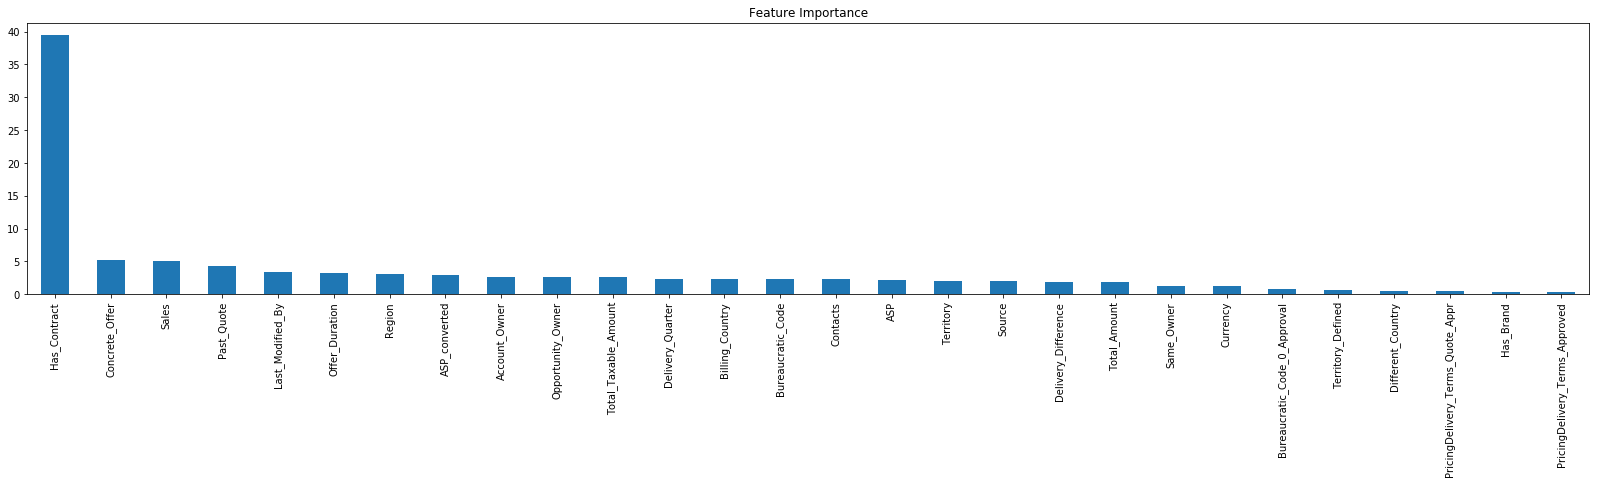

In [820]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [821]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [822]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote,Prediction
7812,APAC,Australia,1,0,1,0,Bureaucratic_Code_5,None,Australia,4832,2252,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,317,181.0,130.0,True,131.0,0.876408
4773,APAC,India,1,1,1,1,Bureaucratic_Code_4,Source_13,Sri Lanka,2824,904,Person_Name_49,Person_Name_49,None,Person_Name_47,0.3600,0.36000,Q4,157172.40,157172.40,0,1,19.0,False,False,True,True,0.0,31,72.0,72.0,True,-27.0,0.998233
9545,EMEA,Germany,0,0,0,0,Bureaucratic_Code_4,Source_9,Germany,6045,None,Person_Name_13,Person_Name_13,None,Person_Name_47,0.4200,0.47506,Q3,30450.00,82700.00,1,2,4.0,False,False,False,False,0.0,125,32.0,4.0,True,160.0,0.473259
9800,APAC,Thailand,0,0,0,0,Bureaucratic_Code_4,Source_7,Thailand,6207,3436,Person_Name_54,Person_Name_54,None,Person_Name_47,0.4000,0.40000,Q4,120060.00,120060.00,0,1,0.0,False,False,True,False,0.0,1,86.0,57.0,True,70.0,0.971816
952,EMEA,Germany,1,0,0,0,Bureaucratic_Code_5,Source_7,Germany,511,1344,Person_Name_4,Person_Name_4,None,Person_Name_41,0.3875,0.43830,Q2,287525.00,287525.00,0,1,12.0,False,False,True,False,1.0,17,88.0,8.0,True,603.0,0.996310
16800,EMEA,None,0,0,0,0,Bureaucratic_Code_4,None,Luxembourg,12726,None,Person_Name_18,Person_Name_20,None,Person_Name_20,0.5400,0.61079,Q1,105300.00,105300.00,1,1,3.0,True,False,False,False,0.0,2,86.0,72.0,False,-8.0,0.101253
9280,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,None,United States,5834,2880,Person_Name_64,Person_Name_64,None,Person_Name_47,0.4300,0.43000,Q4,30702.00,30702.00,0,1,0.0,False,False,True,True,0.0,22,132.0,4.0,True,183.0,0.816659
10407,Americas,None,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,6515,3390,Person_Name_33,Person_Name_33,None,Person_Name_47,0.4950,0.49500,Q1,285862.50,285862.50,0,1,30.0,False,False,True,False,1.0,73,89.0,NaN,False,NaN,0.989840
7806,APAC,Australia,1,1,1,1,Bureaucratic_Code_4,None,Australia,4826,2247,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,317,181.0,130.0,True,131.0,0.547387
2607,EMEA,France,1,0,0,0,Bureaucratic_Code_5,None,France,1451,337,Person_Name_16,Person_Name_16,None,Person_Name_47,0.5050,0.57120,Q3,254267.50,507020.00,0,2,7.0,False,False,True,False,1.0,6,186.0,67.0,True,181.0,0.672705


In [847]:
bad.Stage.value_counts()

0    79
1    20
Name: Stage, dtype: int64

In [24]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission_11.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9917449944388407

In [25]:
answer.to_csv("submission_23.csv", header = False, index = False)

In [29]:
p = prev.merge(answer, on = "Opportunity_ID")

In [31]:
p["New_Prediction"] = (p.Prediction_x + p.Prediction_y) / 2.0

In [38]:
pp = p[["Opportunity_ID", "New_Prediction"]]
pp.to_csv("submission_24.csv", header = False, index = False)